<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Utility-functions" data-toc-modified-id="Utility-functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Utility functions</a></span></li><li><span><a href="#Load-data-and-preprocessing" data-toc-modified-id="Load-data-and-preprocessing-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load data and preprocessing</a></span></li></ul></li><li><span><a href="#Hyperparameter-tuning" data-toc-modified-id="Hyperparameter-tuning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Hyperparameter tuning</a></span><ul class="toc-item"><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Model-Evaluation" data-toc-modified-id="Model-Evaluation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model Evaluation</a></span><ul class="toc-item"><li><span><a href="#Train-test-split" data-toc-modified-id="Train-test-split-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Train test split</a></span></li><li><span><a href="#Logistic-Regressoin" data-toc-modified-id="Logistic-Regressoin-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Logistic Regressoin</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Test-set-prediction" data-toc-modified-id="Test-set-prediction-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Test set prediction</a></span><ul class="toc-item"><li><span><a href="#Data-laoding-and-preprocessing-for-LightGBM" data-toc-modified-id="Data-laoding-and-preprocessing-for-LightGBM-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Data laoding and preprocessing for LightGBM</a></span></li></ul></li></ul></div>

# Preprocessing

In [99]:
## Read in csv file for Surgical Deepnet data that is stored in path:
import itertools
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization

from preprocessor import Preprocessor
from logisticOptimizer import LogisticOptimizer
from randomforestOptimizer import RandomForestOptimizer
from lightgbmOptimizer import LightgbmOptimizerBinary

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', 5)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Utility functions

In [81]:
def feature_generation(data):
    ### datetime: int
    data['proc_create_DT_delta'] = (data['PROC_DATE'] - data['CREATE_DT_TM']).dt.days
    ## convert three datetime columns to referencex date: int
    reference_date = pd.datetime(2017, 12, 31)
    data['CREATE_DT_TM'] = (data['CREATE_DT_TM'] - reference_date).dt.days
    data['SCHED_START_DT_TM'] = (data['SCHED_START_DT_TM'] - reference_date).dt.days
    data['PROC_DATE'] = (data['PROC_DATE'] - reference_date).dt.days
    ### age: float
    data['age_diff'] = data['AGE_ON_CONTACT_DATE'] - data['CAV_REC_AGE']
    ### is_bp_diastolic_normal: boolean
    data['is_BP_DIASTOLIC_normal'] = data['BP_DIASTOLIC'].map(lambda x: x >= 60 and x <= 90)
    ### Is_bp_systolic_normal: boolean
    data['is_BP_SYSTOLIC_normal'] = data['BP_SYSTOLIC'].map(lambda x: x >= 90 and x <= 130)
    ### hypertenssion: boolean
    data['hypertension'] = (data['BP_DIASTOLIC'] >= 90) & (data['BP_SYSTOLIC'] >= 140)
    ### is_pulse_normal: boolean
    data['is_pulse_normal'] = data['PULSE'].map(lambda x: x >= 60 and x <= 100)
    return data

def find_optimal_threshold(fpr, tpr, thresholds):
    idx = np.arange(len(thresholds)) 
    roc = pd.DataFrame({'tf': pd.Series(tpr+fpr-1, index=idx).abs(),
                        'thresholds': pd.Series(thresholds, index=idx)})
    return roc.sort_values(by='tf', axis=0, ascending=True).iloc[0]

## Load data and preprocessing

In [77]:
## datetime features
datetime_cols = ['PROC_DATE', 'CREATE_DT_TM', 'SCHED_START_DT_TM']
## integer features
int_cols = ['CAV_REC_AGE']
## category features
cate_cols = ['SCHED_SURG_AREA', 'RACE', 'ETHNIC_GROUP', 'SCHED_HOSPITAL', 'SCHED_SURG_PROC_CD', 'FEMALE', 'CAV_REC_SEX', 'CAV_REC_LANG', 'CAV_REC_IPOP', 'CAV_REC_PRIORITY_CODE', 'CAV_REC_DISP_CODE']
## boolean features
bool_cols = ['PCPVISIT', 'METFORMIN_FLAG', 'OPIOIDS_FLAG', 'ALPHA_BLOCKERS', 'CENTRAL_ANTAGONISTS', 'RENIN', 'BETA_BLOCKERS', 'ACE_INHIB', 'ARB', 'ALDOSTERONE_BLOCKERS', 'VASODIALATORS', 'DIURETICS', 'CALCIUM_BLOCKERS', 'STATINS', 'INSULIN_MEDS', 'ASPIRIN', 'WARFARIN', 'DOACS', 'PRETERM_17P', 'MEDROL', 'PREDNISONE', 'INHALED_STEROID_WITH_LABA', 'INHALED_STEROID_WITHOUT_LABA', 'INHALED_STEROIDS', 'ASTHMA_BIOLOGICS', 'SHORT_ACTING_BRONCHO_DIALATORS', 'TNF_INHIBITORS', 'IMMUNOMODULATORS', 'AMINOSALICYLATES', 'CORTICOSTEROIDS', 'ARNI', 'ALLOPURINOL', 'SEIZURE', 'MUSCLERELAXANT', 'DIGOXIN', 'INOTROPES', 'ANTI_ARRHYTHMIC', 'ANTIPLATELET', 'SULFONYLUREA', 'GLP_1_AGONIST', 'THIAZOLIDINEDIONE', 'SGLT2_INHIBITOR', 'DPP4_INHIBITOR', 'ALPHA_GLUCOSIDASE_INHIBITOR', 'AMYLINOMIMETIC', 'RAPID_ACTING_INSULIN', 'SHORT_ACTING_INSULIN', 'INTERMEDIATE_ACTING_INSULIN', 'LONG_ACTING_INSULIN', 'MINOCYCLINE', 'DOXYCYCLINE', 'MELATONIN', 'METHAZOLAMIDE', 'HYDROXYCHLOROQUINE', 'ITTC', 'DMARDS', 'OBESE_HST', 'MORBIDOBESE_HST', 'PH_HST', 'AFIB_HST', 'COPD_HST', 'CHF_HST', 'DIAB_HST', 'CAD_HST', 'OSTEO_HST', 'HTN_HST', 'CANCER_HST', 'LUNG_CANCER_HST', 'OVARIAN_CANCER_HST', 'HEAD_NECK_CANCER_HST', 'BREAST_CANCER_HST', 'ASTHMA_HST', 'GERD_HST', 'FIBROMYALGIA_HST', 'DEPRESSION_HST', 'PSORIATIC_ARTHRITIS_HST', 'RHEUM_ARTHRITIS_HST', 'LUPUS_HST', 'VTVF_HST', 'STROKE_HST', 'VASCULARDISEASE_HST', 'LOWBACKPAIN_HST', 'DVT_HST', 'PE_HST', 'HYPOTHYROIDISM_HST', 'ADRENAL_INSUFFICIENCY_HST', 'INFERTILITY_HST', 'CKD_HST', 'ESRD_HST', 'OBS_SLEEPAPNEA_HST' , 'CARDIAC_ARREST_HST', 'HEMO_STROKE_HST', 'MAJOR_BLEED_HST', 'MACULAR_DEGEN_HST', 'ANXIETY_HST', 'HYPERLIPIDEMIA_HST', 'HIV_HST', 'ALZHEIMER_HST', 'COLORECTAL_CANCER_HST', 'ENDOMETRIAL_CANCER_HST', 'GLAUCOMA_HST', 'HIP_PELVIC_FRACTURE_HST', 'BENIGN_PROSTATIC_HYPERPLASIA_HST', 'CIRRHOSIS_HST', 'CIRRHOSIS_HST_1']

In [78]:
preprocessor = Preprocessor(data_path='./data/PYTHON_LAB_TRAIN.csv', \
                            data_type='csv', \
                            parse_dates=datetime_cols)
preprocessor.drop_null(0.5, 0.1)
preprocessor.fill_na('ffill')
preprocessor.fill_na('bfill')
preprocessor.feature_encoding(cate_cols)
preprocessor.convert_dtypes(int_cols=int_cols, cate_cols=cate_cols, bool_cols=bool_cols)
## feature generation
preprocessor.data = feature_generation(preprocessor.data)
## scaling data
preprocessor.scaling(cate_cols)
## drop duplicated feature(s)
preprocessor.drop_cols(['FEMALE'])
## target preprocessing
preprocessor.data['target'] = preprocessor.data['LOS'] > 5

Preproocessor initializing...
Loading data from './data/PYTHON_LAB_TRAIN.csv'... Parsing datetime... Finished.
Finished.
Dropping column(s) and row(s) with ratio 0.50 and 0.10 respectively... Finished.
Fill null values... Finished.
Fill null values... Finished.
Feature encoding... Finished.
Dropping specific column(s)... Finished.


# Hyperparameter tuning

## RandomForest

In [83]:
base_params = {'bootstrap': True, \
               'oob_score': False, \
               'n_jobs': 4, \
               'random_state': 1213, \
               'warm_start': False, \
               'class_weight': 'balanced_subsample'}

cat_params = {'criterion': ['gini', 'entropy']}

int_params = {'n_estimators': (10, 500, 10), \
              'max_depth': (1, 50, 1), \
              'min_samples_split': (2, 500, 2), \
              'min_samples_leaf': (1, 250, 1), \
              'max_leaf_nodes': (2, 1024, 4)}

float_params = {'min_weight_fraction_leaf': (0, 0.5), \
                'min_impurity_decrease': (0, 1), \
                'max_features': (0.1, 1)}

In [ ]:
rf_optimizer = RandomForestOptimizer(X_train, y_train, X_eval, y_eval, X_test, y_test, \
                               base_params, cat_params, int_params, float_params, \
                               num_opts=1000, trials_path='./RandomForest_hyperopt_trials/trials.pkl', load_trials=False)

## LightGBM

In [84]:
base_params = {'task': 'train', \
               'objective': 'binary', \
               'tree_learner': 'serial', \
               'num_threads': 4, \
               'device_type': 'cpu', \
               'seed': 1213, \
               'bagging_seed': 42, \
               'feature_fraction_seed': 3, \
               'first_metric_only': False, \
               'max_delta_step': 0, \
               'bin_construct_sample_cnt': 200000, \
               'histogram_pool_size': -1, \
               'is_unbalance': True, \
               'metric': 'auc,binary_logloss,binary_error', \
               'metric_freq': 1}

cat_params = {'boosting': ['gbdt']}

int_params = {'num_leaves': (2, 1024, 8), \
              'max_depth': (1, 100, 1), \
              'min_data_in_leaf': (2, 500, 4), \
              'bagging_freq': (0, 100, 1), \
              'min_data_per_group': (100, 500, 10), \
              'max_cat_threshold': (16, 256, 2), \
              'max_cat_to_onehot': (1, 100, 1), \
              'max_bin': (127, 511, 2), \
              'min_data_in_bin': (3, 128, 8)}

float_params = {'min_sum_hessian_in_leaf': (0, 0.1), \
                'bagging_fraction': (0.1, 1), \
                'pos_bagging_fraction': (0.1, 1), \
                'neg_bagging_fraction': (0.1, 1), \
                'feature_fraction': (0.1, 1), \
                'feature_fraction_bynode': (0.1, 1), \
                'lambda_l1': (0, 500), \
                'lambda_l2': (1000, 4000), \
                'sigmoid': (0.1, 500), \
                'cat_l2': (10, 1000), \
                'cat_smoth': (10, 1000), \
                'min_gain_to_split': (0, 100)}

In [ ]:
lgb_hyperopt = lightgbm_hyperopt_binary(X_train, y_train, X_eval, y_eval, X_test, y_test, \
                                        base_params, cat_params, int_params, float_params, \
                                        num_opts=50, trials_path='./Lightgbm_hyperopt_trials/trials.pkl', load_trials=True)

# Model Evaluation

## Train test split

In [225]:
X_train, X_test, y_train, y_test = train_test_split(lab_df.drop(['LOS', 'target'], axis=1), lab_df['target'], test_size=0.25)

## Logistic Regressoin

In [63]:
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

In [44]:
## optimal hyperparameters
params = {'C': 0.35938136638046203, \
          'penalty': 'elasticnet', \
          'tol': 0.0001, \
          'class_weight': 'balanced', \
          'l1_ratio': 0.75, \
          'solver': 'saga', \
          'max_iter': 5000, \
          'n_jobs': 4}

In [47]:
## train model
logistic_clf = LogisticRegression(**params).fit(X_train, y_train)

In [56]:
## save model
pickle.dump(logistic_clf, open('./models/logisticRegression.pkl', 'wb'))

In [61]:
## prediction
y_train_pred_prob = logistic_clf.predict_proba(X_train)[:, 1]
y_test_pred_prob = logistic_clf.predict_proba(X_test)[:, 1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)

In [88]:
## AUC scores
auc_train = roc_auc_score(y_train, y_train_pred_prob)
auc_test = roc_auc_score(y_test, y_test_pred_prob)
auc_diff = auc_train - auc_test
print(f'The training AUC is {auc_train:.2f}\n'\
      f'The testing AUC is {auc_test:.2f}\n'\
      f'The difference btw. training and testing is {auc_diff:.4f}')

The training AUC is 0.74
The testing AUC is 0.75
The difference btw. training and testing is -0.0017


In [71]:
## optimize threshold
optimal_threshold = find_optimal_threshold(fpr_test, tpr_test, thresholds_test)['thresholds']

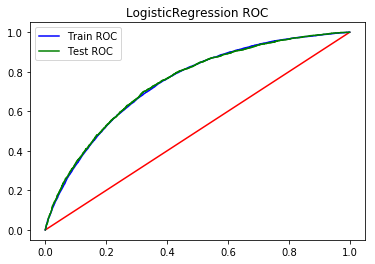

In [84]:
## plot roc
plt.plot([0, 1], [0, 1], color='red')
plt.plot(fpr_train, tpr_train, label='Train ROC', color='blue')
plt.plot(fpr_test, tpr_test, label='Test ROC', color='green')
plt.legend()
plt.title('LogisticRegression ROC')
plt.show()

## RandomForest

In [102]:
from sklearn.ensemble import RandomForestClassifier

In [91]:
trials = pickle.load(open('./RandomForest_hyperopt_trials/trials.pkl', 'rb'))

In [101]:
## optimal hyperparameters
trials.best_trial['misc']['vals']

{'criterion': [1],
 'max_depth': [42],
 'max_features': [0.5498990351888509],
 'max_leaf_nodes': [228],
 'min_impurity_decrease': [0.000956478290154218],
 'min_samples_leaf': [139],
 'min_samples_split': [142],
 'min_weight_fraction_leaf': [1.9761111605676174e-06],
 'n_estimators': [25]}

In [226]:
params = {'n_estimators': 25, \
          'criterion': 'entropy', \
          'max_depth': 42, \
          'min_samples_split': 142, \
          'min_samples_leaf': 139, \
          'min_weight_fraction_leaf': 1.9761111605676174e-06, \
          'max_features': 0.5498990351888509, \
          'max_leaf_nodes': 228, \
          'min_impurity_decrease': 0.000956478290154218, \
          'n_jobs': 4, \
          'class_weight': 'balanced'}

In [227]:
## train model
rf_clf = RandomForestClassifier(**params).fit(X_train, y_train)
## save model
pickle.dump(rf_clf, open('./models/RandomForest.pkl', 'wb'))

In [228]:
## prediction
y_train_pred_prob = rf_clf.predict_proba(X_train)[:, 1]
y_test_pred_prob = rf_clf.predict_proba(X_test)[:, 1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)

In [229]:
## AUC scores
auc_train = roc_auc_score(y_train, y_train_pred_prob)
auc_test = roc_auc_score(y_test, y_test_pred_prob)
auc_diff = auc_train - auc_test
print(f'The training AUC is {auc_train:.2f}\n'\
      f'The testing AUC is {auc_test:.2f}\n'\
      f'The difference btw. training and testing is {auc_diff:.4f}')

The training AUC is 0.79
The testing AUC is 0.78
The difference btw. training and testing is 0.0139


In [230]:
## optimize threshold
optimal_threshold = find_optimal_threshold(fpr_test, tpr_test, thresholds_test)['thresholds']

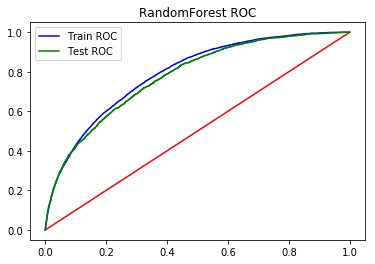

In [231]:
## plot roc
plt.plot([0, 1], [0, 1], color='red')
plt.plot(fpr_train, tpr_train, label='Train ROC', color='blue')
plt.plot(fpr_test, tpr_test, label='Test ROC', color='green')
plt.legend()
plt.title('RandomForest ROC')
plt.show()

## LightGBM

In [112]:
import lightgbm as lgb

In [113]:
trials = pickle.load(open('./Lightgbm_hyperopt_trials//trials.pkl', 'rb'))

In [116]:
## optimal hyperparameters
trials.best_trial['misc']['vals']

{'bagging_fraction': [0.5328606157852269],
 'bagging_freq': [13],
 'boosting': [0],
 'cat_l2': [282.1088468478816],
 'cat_smoth': [872.24054600045],
 'feature_fraction': [0.12843913539981874],
 'feature_fraction_bynode': [0.6779409466942411],
 'lambda_l1': [380.0876729734785],
 'lambda_l2': [1846.2881071591921],
 'max_bin': [179],
 'max_cat_threshold': [112],
 'max_cat_to_onehot': [6],
 'max_depth': [0],
 'min_data_in_bin': [3],
 'min_data_in_leaf': [74],
 'min_data_per_group': [17],
 'min_gain_to_split': [77.17261768423568],
 'min_sum_hessian_in_leaf': [0.08005933144430555],
 'neg_bagging_fraction': [0.6635583589354656],
 'num_leaves': [41],
 'pos_bagging_fraction': [0.8548722861693099],
 'sigmoid': [35.67201038953876]}

In [195]:
base_params = {'task': 'train', \
               'objective': 'binary', \
               'tree_learner': 'serial', \
               'num_threads': 4, \
               'device_type': 'cpu', \
               'seed': 1213, \
               'bagging_seed': 42, \
               'feature_fraction_seed': 3, \
               'first_metric_only': False, \
               'max_delta_step': 0, \
               'bin_construct_sample_cnt': 200000, \
               'histogram_pool_size': -1, \
               'is_unbalance': True, \
               'metric': 'auc,binary_logloss,binary_error', \
               'metric_freq': 1}

params = {'boosting': 'gbdt', \
          'num_leaves': 41, \
          'max_depth': 0, \
          'min_data_in_leaf': 74, \
          'bagging_freq': 13, \
          'min_data_per_group': 17, \
          'max_cat_threshold': 112, \
          'max_cat_to_onehot': 6, \
          'max_bin': 179, \
          'min_data_in_bin': 3, \
          'min_sum_hessian_in_leaf': 0.08005933144430555, \
          'bagging_fraction': 0.5328606157852269, \
          'pos_bagging_fraction': 0.8548722861693099, \
          'neg_bagging_fraction': 0.6635583589354656, \
          'feature_fraction': 0.12843913539981874, \
          'feature_fraction_bynode': 0.6779409466942411, \
          'lambda_l1': 380.0876729734785, \
          'lambda_l2': 1846.2881071591921, \
          'sigmoid': 35.67201038953876, \
          'cat_l2': 35.67201038953876, \
          'cat_smoth': 872.24054600045, \
          'min_gain_to_split': 77.17261768423568}
all_params = dict(base_params, **params)

In [196]:
## train model
lgb_clf = lgb.LGBMClassifier(**all_params, num_boost_round=4000, learning_rate=0.03).fit(X_train, y_train)
## save model
pickle.dump(lgb_clf, open('./models/LightGBM.pkl', 'wb'))

/Users/kaimo/Python-project/venv/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [197]:
## prediction
y_train_pred_prob = lgb_clf.predict_proba(X_train)[:, 1]
y_test_pred_prob = lgb_clf.predict_proba(X_test)[:, 1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)

In [198]:
## AUC scores
auc_train = roc_auc_score(y_train, y_train_pred_prob)
auc_test = roc_auc_score(y_test, y_test_pred_prob)
auc_diff = auc_train - auc_test
print(f'The training AUC is {auc_train:.2f}\n'\
      f'The testing AUC is {auc_test:.2f}\n'\
      f'The difference btw. training and testing is {auc_diff:.4f}')

The training AUC is 0.87
The testing AUC is 0.86
The difference btw. training and testing is 0.0063


In [199]:
## optimize threshold
optimal_threshold = find_optimal_threshold(fpr_test, tpr_test, thresholds_test)['thresholds']

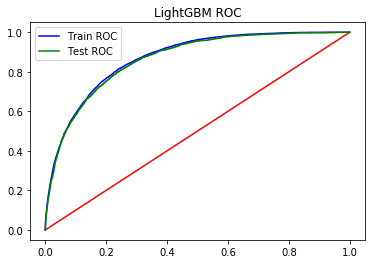

In [202]:
## plot roc
plt.plot([0, 1], [0, 1], color='red')
plt.plot(fpr_train, tpr_train, label='Train ROC', color='blue')
plt.plot(fpr_test, tpr_test, label='Test ROC', color='green')
plt.legend()
plt.title('LightGBM ROC')
plt.show()

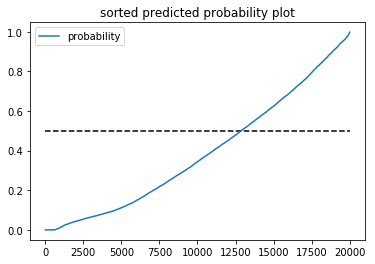

In [201]:
##### sorted predicted probability plot
# x-axis is the index
# y-axis is the probability
plt.plot(range(len(sorted(y_test_pred_prob))), sorted(y_test_pred_prob), label='probability')
plt.hlines(0.5, xmin=0, xmax=len(sorted(y_test_pred_prob)), linestyles='dashed')
plt.legend()
plt.title('sorted predicted probability plot')
plt.show()

# Test set prediction

## Data laoding and preprocessing for LightGBM

In [97]:
preprocessor = Preprocessor(data_path='./data/PYTHON_LAB_DF_TEST_2.csv', \
                            data_type='csv', \
                            parse_dates=datetime_cols)
preprocessor.feature_encoding(cate_cols)
preprocessor.convert_dtypes(cate_cols=cate_cols, bool_cols=bool_cols)
## feature generation
preprocessor.data = feature_generation(preprocessor.data)
## drop duplicated feature(s)
preprocessor.drop_cols(['FEMALE'])

Preproocessor initializing...
Loading data from './data/PYTHON_LAB_DF_TEST_2.csv'... Parsing datetime... Finished.
Finished.
Feature encoding... Finished.
Dropping specific column(s)... Finished.


In [100]:
## load lightgbm model
lgb_clf = pickle.load(open('./models/LightGBM.pkl', 'rb'))
## predict
LOS_pred = lgb_clf.predict_proba(preprocessor.data.drop('ID1', axis=1))[:, 1]
submission_df = pd.DataFrame.from_dict({'ID1': preprocessor.data['ID1'].values, 'LOS_PROB': LOS_pred})
## save prediction
submission_df.to_csv('./submission/submission1.csv', index=False)